# Survival Models

Survival models, also known as time-to-event models, are specialized statistical methods designed to analyze the time until the occurrence of an event of interest. In this notebook, a review of survival analysis  and censored data is provided, followed by a survival model implementation in Bambi.

## Survival and censoring times

Sometimes the right way to model discrete, countable events is to model not the counts themselves but rather the **time between events**. This gives us information regarding the rate of an event. Survival models are models for countable things, but the outcomes we want to predict are durations. Durations are continuous deviations from some point of reference (so they are all positive values). 

The tricky part with survival models is not the probability distribution assigned to the durations, but dealing with censoring. Censoring occurs when the event of interest does not occur in the window of observation. In a simple scenario, this can happen because the observation period ends before the event occurred. Censored individuas (or units) can not just be dropped from the sample. Imagine a cohort of 100 cats who start waiting for adoption at the same time. After one month, half of them have been adopted. Now what is the rate of adoption? You can’t compute it using only the cats who have been adopted. You need to also account for the cats who haven’t yet been adopted. The cats who haven’t been adopted yet, but eventually will be adopted, clearly have longer waiting times than the cats who have already been adopted. So the average rate among those who are already adopted is biased upwards—it is confounded by conditioning on adoption.

Including censored observations requires a new type of model. The key idea is that the same distribution assumption for the outcome tells us both the probability of any observed duration that end in the event as well as the probability that we would wait the observed duration without seeing the event. For each unit, we assume there is a true _survival time_ $T$ as well as a true censoring time $C$. The survival time represents the time at which the event of interest occurs. The censoring time is the time at which censoring occurs. We observe either: the survival, or the censoring time:

$$Y = \text{min}(T, C)$$

If the event occurs, then we observe the survival time, else we observe the censoring time. In order to analyze survival data, we first need to understand the two main types of censoring: left and right censoring, and how to estimate the survival function.

## Left and right censoring

There are two main "types" of censoring: right and left. Right sensoring occurs when $T \ge Y$, i.e. the true event time $T$ is at least as large as the observed time $Y$. This is a consequence of $Y = \text{min}(T, C)$. Right censoring derives its name from the fact that time is typically displayed from left to right. Left sensoring occurs when the true event time $T$ is less than or equal to the observed time $Y$. 

**TO DO**: give an example of right and left censoring.

## Estimating the survival function

Survival analysis is concerned with estimating the survival function $S(t)$

$$S(t) = Pr(T > t) = 1 - F(t)$$

which is a decreasing function that quantifies the probability of surviving past time $t$. Alternatively, $S(t)$ can be expressed as one minus the cumulative distribution function (CDF) $F$ of the event time $T$—referred to as the complementary cumulative distribution function (CCDF). The focus on the survival function is important because for censored observations, we only know that the time-to-event exceeds the observed time $Y$.

Here, continuing with the cat adoption example, we consider the task of estimating the survival function for cat adoptions. To estimate $S(30) = Pr(T > 30)$, the probability that a cat is not adopted after 30 days, it is tempting to compute the proportion of cats who were adopted before 30 days and subtract this from 1. However, this would be incorrect because it ignores the cats who were not adopted before 30 days but who **will be** adopted later—these cats clearly have longer adoption rates. Thus, if we continued with the naive approach, the average rate of adoption would be biased upwards—it is confounded by conditioning on adoption.

However, it is possible to overcome this challenge by using the Kaplan-Meier estimator. The Kaplan-Meier estimator is a non-parametric estimator of the survival function that accounts for censoring. Let $d_1 < d_2 < . . . < d_K$ denote the $K$ unique adoption times among the non-censored cats, and $q_k$ denote the number of cats adopted at time $d_k$. For $k = 1,...,K$, let $r_k$ denote the number of cats not adopted at time $d_k$. By the law of total probability

$$Pr(T > d_k) = Pr(T > d_k | T > d_{k-1}) Pr(T > d_{k-1}) + Pr(T > d_k | T \leq d_{k-1}) Pr(T \leq d_{k-1})$$

The fact that $d_{k-1} < d_k$ implies that $Pr(T > d_k | T \leq d_{k-1}) = 0$ (as it is impossible for a cat to be adopted past time $d_k$ if the cat was adopted before time $d_{k-1}$). Thus, if we simplify the above equation and plug into the survival function, we obtain

$$S(d_k) = Pr(T > d_k | T > d_{k-1})S(d_{k-1})$$

Now we must estimate the terms on the right-hand side. It is common to use the following estimator 

$$\hat{Pr}(T > d_j | T > d_{j-1}) = \frac{r_j - q_j}{r_j}$$

which leads us to the Kaplan-Meier estimator of the survival function

$$\hat{S}(d_k) = \prod_{j=1}^k \frac{r_j - q_j}{r_j}$$

Below is a Python function implementing the Kaplan-Meier estimator.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/AustinCats.csv"
cats = pd.read_csv(url, sep=";")

cats_new = cats.copy()
cats_new["adopt"] = np.where(cats_new["out_event"] == "Adoption", "right", "none")
cats_new["color_id"] = np.where(cats_new["color"] == "Black", 1, 0)
cats_new = cats_new[["days_to_event", "adopt", "color_id"]]

In [3]:
cats_new

,days_to_event,adopt,color_id
0,1,none,0
1,25,none,0
2,4,right,0
3,41,none,0
4,9,none,0
...,...,...,...
22351,10,none,0
22352,5,none,0
22353,6,none,0
22354,9,none,0


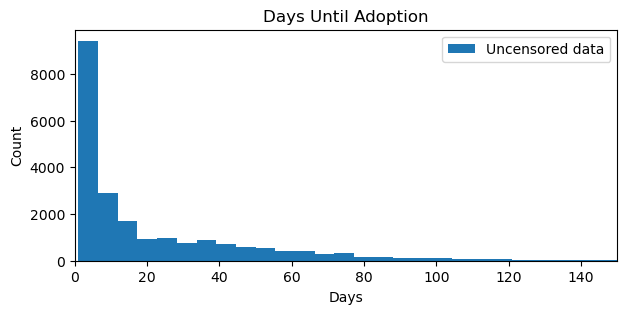

In [4]:
plt.figure(figsize=(7, 3))
plt.hist(cats_new["days_to_event"], bins=250, label="Uncensored data")
plt.xlim(0, 150) # truncate for visibility
plt.title("Days Until Adoption")
plt.ylabel("Count")
plt.xlabel("Days")
plt.legend();

In [5]:
def kaplan_meier_estimator(d_k, d, times):
    """
    Compute the Kaplan-Meier estimator.

    Parameters:
    -----------
    - d_k: np.ndarray
        Array of unique observed event times.
    - d: np.ndarray
        Array indicating if the event occurred at the time from the 'd_k' list;
        True if event occurred, False if censored.
    - times: np.ndarray
        Array of times at which the survival function should be evaluated.

    Returns:
    --------
    - List of Kaplan-Meier estimates at the specified 'times'.
    """

    n = len(d_k)
    survival = []
    s_prev = 1

    for time in times:
        product = s_prev
        for i in range(n):
            if d_k[i] <= time:
                product *= (1 - d[i] / (n - i))
        survival.append(product)
        s_prev = product

    return survival

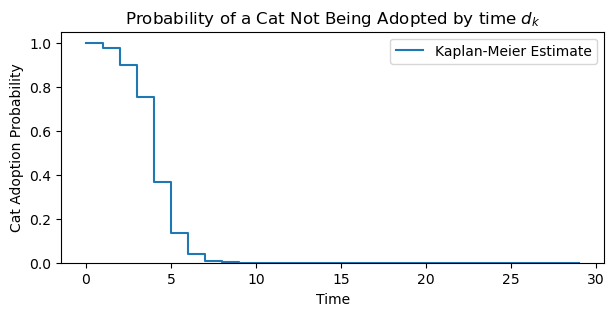

In [6]:
observed_adoption_times = cats_new[cats_new["adopt"] == "right"]["days_to_event"].values
adoption = (cats_new["adopt"] == "right").values
evaluation_times = np.arange(0, 30, 1)
adoption_km_estimates = kaplan_meier_estimator(
    observed_adoption_times, adoption, evaluation_times
)

plt.figure(figsize=(7, 3))
plt.step(evaluation_times, adoption_km_estimates, where="post", label="Kaplan-Meier Estimate")
plt.xlabel("Time")
plt.ylabel("Cat Adoption Probability")
plt.title("Probability of a Cat Not Being Adopted by time $d_k$")
plt.ylim(0, 1.05)
plt.legend()
plt.show()

## Adding predictors

It is often the case that we would like to understand how various predictors are associated with the survival function. For example, we may want to know if the survival function for cats of different colors or species is different. 

## Implementation in Bambi

### Cat adoptions

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


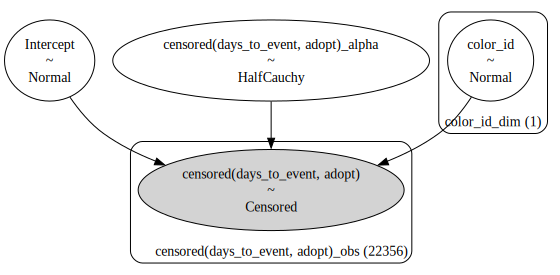

In [7]:
model = bmb.Model(
    "censored(days_to_event, adopt) ~ 1 + color_id", 
    cats_new,
    categorical=["color_id"],
    family="weibull",
    link="log"
)

model.build()
model.graph()

In [8]:
model

       Formula: censored(days_to_event, adopt) ~ 1 + color_id
        Family: weibull
          Link: mu = log
  Observations: 22356
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.6843)
            color_id ~ Normal(mu: 0.0, sigma: 7.3709)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)

In [9]:
idata = model.fit(tune=250, draws=250, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(days_to_event, adopt)_alpha, Intercept, color_id]


Sampling 4 chains for 250 tune and 250 draw iterations (1_000 + 1_000 draws total) took 365 seconds.


In [11]:
az.summary(idata)

/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.670,0.025,4.622,4.719,0.001,0.001,548.0,516.0,1.00
color_id[1],0.075,0.050,-0.016,0.164,0.002,0.001,676.0,661.0,1.00
"censored(days_to_event, adopt)_alpha",0.545,0.004,0.536,0.552,0.000,0.000,572.0,532.0,1.01


In [30]:
idata["posterior"]["censored(days_to_event, adopt)_alpha"]

<xarray.DataArray 'censored(days_to_event, adopt)_alpha' (chain: 4, draw: 250)>
array([[0.53935333, 0.54798345, 0.54611717, 0.54240415, 0.54516249,
        0.54604198, 0.54010069, 0.53849705, 0.54149216, 0.54141947,
        0.54953115, 0.54964641, 0.54821807, 0.5446591 , 0.54333438,
        0.54728551, 0.5371673 , 0.53966886, 0.54046277, 0.54402676,
        0.54197107, 0.54483295, 0.54240612, 0.54567259, 0.5462763 ,
        0.54568066, 0.5455053 , 0.54016126, 0.54174571, 0.54642298,
        0.54797629, 0.5488662 , 0.5392896 , 0.54867309, 0.54603665,
        0.54789871, 0.54583789, 0.54554217, 0.54340004, 0.5434971 ,
        0.53767273, 0.54077849, 0.54361631, 0.54548055, 0.54405894,
        0.54573845, 0.54243622, 0.54408975, 0.54498281, 0.5435887 ,
        0.54127752, 0.54673364, 0.54333002, 0.54863142, 0.54132778,
        0.54132778, 0.5469205 , 0.54470053, 0.54429434, 0.54132703,
        0.54066905, 0.54146625, 0.54471613, 0.55228284, 0.5499108 ,
        0.54746297, 0.55035778, 0.54741932, 0.5413009 , 0.54518208,
        0.546119  , 0.54899932, 0.55048845, 0.54716592, 0.54639172,
        0.54561098, 0.54180588, 0.54686369, 0.54011188, 0.5427002 ,
        0.54268055, 0.54206934, 0.5387537 , 0.53760288, 0.5364506 ,
        0.53859707, 0.54964921, 0.54369685, 0.54216363, 0.5488324 ,
        0.5465917 , 0.54705156, 0.54289199, 0.54699647, 0.53887363,
        0.54421858, 0.54480015, 0.54794296, 0.54778333, 0.54114178,
...
        0.54568188, 0.54469203, 0.54360096, 0.54470329, 0.5440359 ,
        0.5441919 , 0.54486305, 0.54868088, 0.54792199, 0.5413487 ,
        0.54457818, 0.545425  , 0.54265976, 0.54587295, 0.54067692,
        0.54459498, 0.5427974 , 0.54418402, 0.5400168 , 0.54632363,
        0.55020182, 0.54490868, 0.54620093, 0.55152902, 0.54794462,
        0.54408225, 0.54092639, 0.55172992, 0.55138622, 0.54829111,
        0.54525019, 0.5504665 , 0.54700718, 0.54340513, 0.54841721,
        0.54266158, 0.54251384, 0.5448399 , 0.54559957, 0.53791457,
        0.55508918, 0.54105437, 0.54748245, 0.54184337, 0.54619384,
        0.54340559, 0.54724312, 0.55019283, 0.53819003, 0.54200802,
        0.54521   , 0.54785485, 0.55641238, 0.54875786, 0.54472354,
        0.54583754, 0.53591871, 0.5369457 , 0.53232266, 0.54195518,
        0.54810526, 0.54711663, 0.54573768, 0.54604905, 0.54574217,
        0.5444488 , 0.5420164 , 0.54378072, 0.54343029, 0.53846873,
        0.5429832 , 0.54372525, 0.54343297, 0.54368438, 0.54397053,
        0.54397053, 0.54576662, 0.5458349 , 0.54298961, 0.54332529,
        0.54156595, 0.54068997, 0.54147663, 0.54388949, 0.54588536,
        0.54782986, 0.55084758, 0.54793282, 0.54360948, 0.54097787,
        0.54017977, 0.54756299, 0.54686307, 0.54190148, 0.54067875,
        0.54131165, 0.53914612, 0.54633051, 0.54766087, 0.54077053]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249

In [ ]:
# model.predict(idata, kind="pps", inplace=True)